# Anomaly detection for time series

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

from TSB_UAD.utils.max_mean_discrepancy import calculate_mmd
from TSB_UAD.utils.shapelets import extract_shapelets, calculate_shapelet_similarity
from TSB_UAD.utils.dtw import compute_dtw_distance

from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length
from TSB_UAD.utils.visualisation import plotFig
from sklearn.preprocessing import MinMaxScaler

from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.lof import LOF
from TSB_UAD.models.pca import PCA
from TSB_UAD.models.poly import POLY
from TSB_UAD.models.ocsvm import OCSVM
from TSB_UAD.models.lstm import lstm
from TSB_UAD.models.AE import AE_MLP2
from TSB_UAD.models.cnn import cnn
from TSB_UAD.models.custom_lstm import CustomLstm


##  Data preprocessing

Here we load and prepare the time series (here, we load only a snippet of 10,000 points). We asutomatically estimate the subsequence length for the anomaly detection methods that require a subsequence length parameter.
In order to do this, we use auto-correlation

In [2]:
# Prepare data for unsupervised method

filepath = 'data/TSB-UAD-Artificial/95_2_0.02_35.out'
df = pd.read_csv(filepath, header=None).dropna().to_numpy()

name = filepath.split('/')[-1]
max_length = 10000

data = df[:max_length,0].astype(float)
label = df[:max_length,1].astype(int)
    
slidingWindow = find_length(data)
X_data = Window(window = slidingWindow).convert(data).to_numpy()


# Prepare data for semisupervised method. 
# Here, the training ratio = 0.1

data_train = data[:int(0.1*len(data))]
data_test = data

X_train = Window(window = slidingWindow).convert(data_train).to_numpy()
X_test = Window(window = slidingWindow).convert(data_test).to_numpy()

print("Estimated Subsequence length: ",slidingWindow)
print("Time series length: ",len(data))
print("Number of abnormal points: ",list(label).count(1))

Estimated Subsequence length:  250
Time series length:  10000
Number of abnormal points:  500


# Dataset similarity

Here we are demonstrating and experimenting with datasets that we are trying to find their similarities between them

In [3]:
filepath = 'data/TSB-UAD-Artificial/124_2_0.02_25.out'
df2 = pd.read_csv(filepath, header=None).dropna().to_numpy()
name = filepath.split('/')[-1]
max_length = 10000

data2 = df[:max_length,0].astype(float)
label2 = df[:max_length,1].astype(int)

Use Maximum Mean Discrepancy (MMD) with an RBF kernel to compute pairwise similarities between datasets.

In [4]:
mmd_value = calculate_mmd(data, data2, gamma=1.0)
print("MMD value:", mmd_value)

MMD value: 0.0


Use Dynamic Time Warping (DTW) to find time series alignment/similarity

In [5]:
dtw_value = compute_dtw_distance(data, data2)
print("DTW value:", dtw_value)

DTW value: 0.0


Shapelets are small, discriminative subsequences of a time series that can represent key patterns or features.

1. Extract shapelets from both datasets.
2. Calculate distances between shapelets from both datasets to measure similarity.

In [6]:
import numpy as np
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from sklearn.metrics import pairwise_distances

# Example datasets (replace with your actual datasets)
dataset1 = data
dataset2 = data2

# Reshape datasets to 2D arrays (n_samples, n_timestamps)
dataset1 = dataset1.reshape(1, -1)
dataset2 = dataset2.reshape(1, -1)

# Combine datasets to simulate a multi-class problem
combined_data = np.vstack([dataset1, dataset2])
synthetic_labels = np.array([0, 1])  # Synthetic labels for fitting the model

# Define shapelet sizes based on dataset size
n_shapelets = 5  # Total number of shapelets
shapelet_sizes = grabocka_params_to_shapelet_size_dict(
    n_ts=len(combined_data),        # Number of time series
    ts_sz=combined_data.shape[1],   # Time series length
    n_classes=2,                    # Assuming synthetic labels (2 classes)
    l=0.1,                          # Proportion of time series length for minimum shapelet length (10%)
    r=1                             # Proportion of time series length for maximum shapelet length (100%)
)

# Initialize ShapeletModel
shp_model = ShapeletModel(
    n_shapelets_per_size=shapelet_sizes, 
    optimizer="sgd", 
    weight_regularizer=0.01, 
    max_iter=200
)

# Fit model on the combined data with synthetic labels
shp_model.fit(combined_data, synthetic_labels)

# Transform the datasets using the fitted model
dataset1_shapelets = shp_model.transform(dataset1)
dataset2_shapelets = shp_model.transform(dataset2)

# Compute similarity (e.g., Euclidean distance between transformed shapelet representations)
similarity = pairwise_distances(dataset1_shapelets, dataset2_shapelets, metric='euclidean')
print(f"Similarity between datasets: {similarity[0][0]}")

Similarity between datasets: 0.0


## Display the results of anomaly detectors

For each output figure, the left panel shows the real time series with outliers (red), anomaly score obtained by each anomaly detector, and the correpsonding TP/FP/TN/FN classification. 

The right panel shows the ROC curve. AUC represents the area under the ROC curve. Larger AUC indicates better performance.

0 499
506 506
3906 3906
3914 3921
3925 3926
3928 3973
3975 3975
6896 6953
6958 6965
6967 6970


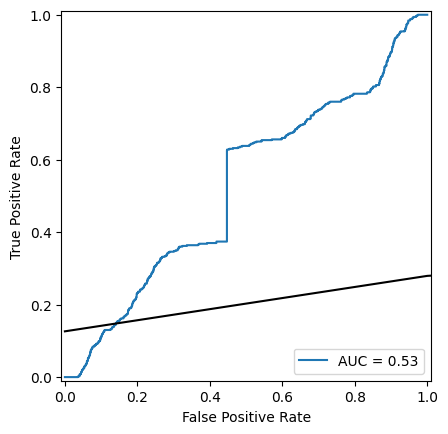

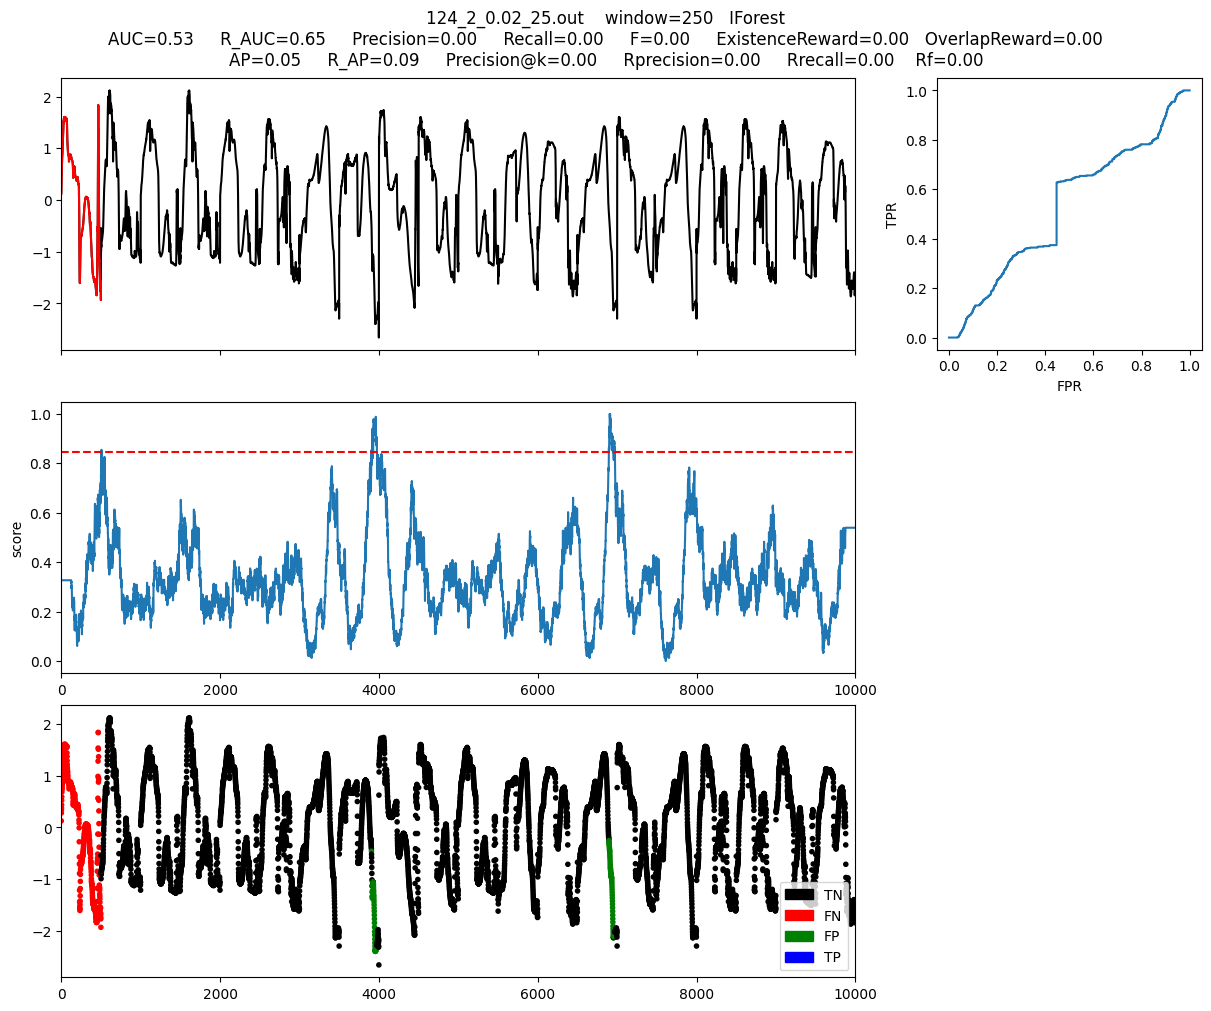

In [7]:
modelName='IForest'
clf = IForest(n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) 

0 499
455 466
3879 3882
4380 4384
4556 4591
4594 4602
4623 4623
5766 5849
6876 6877
7122 7124
9120 9131


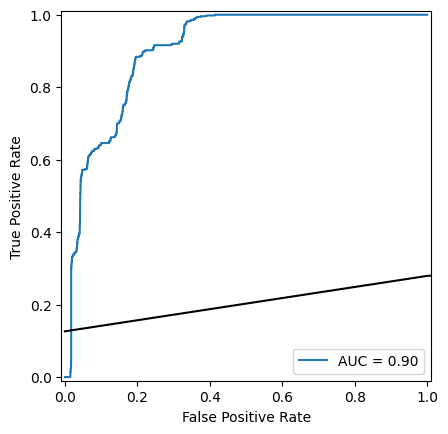

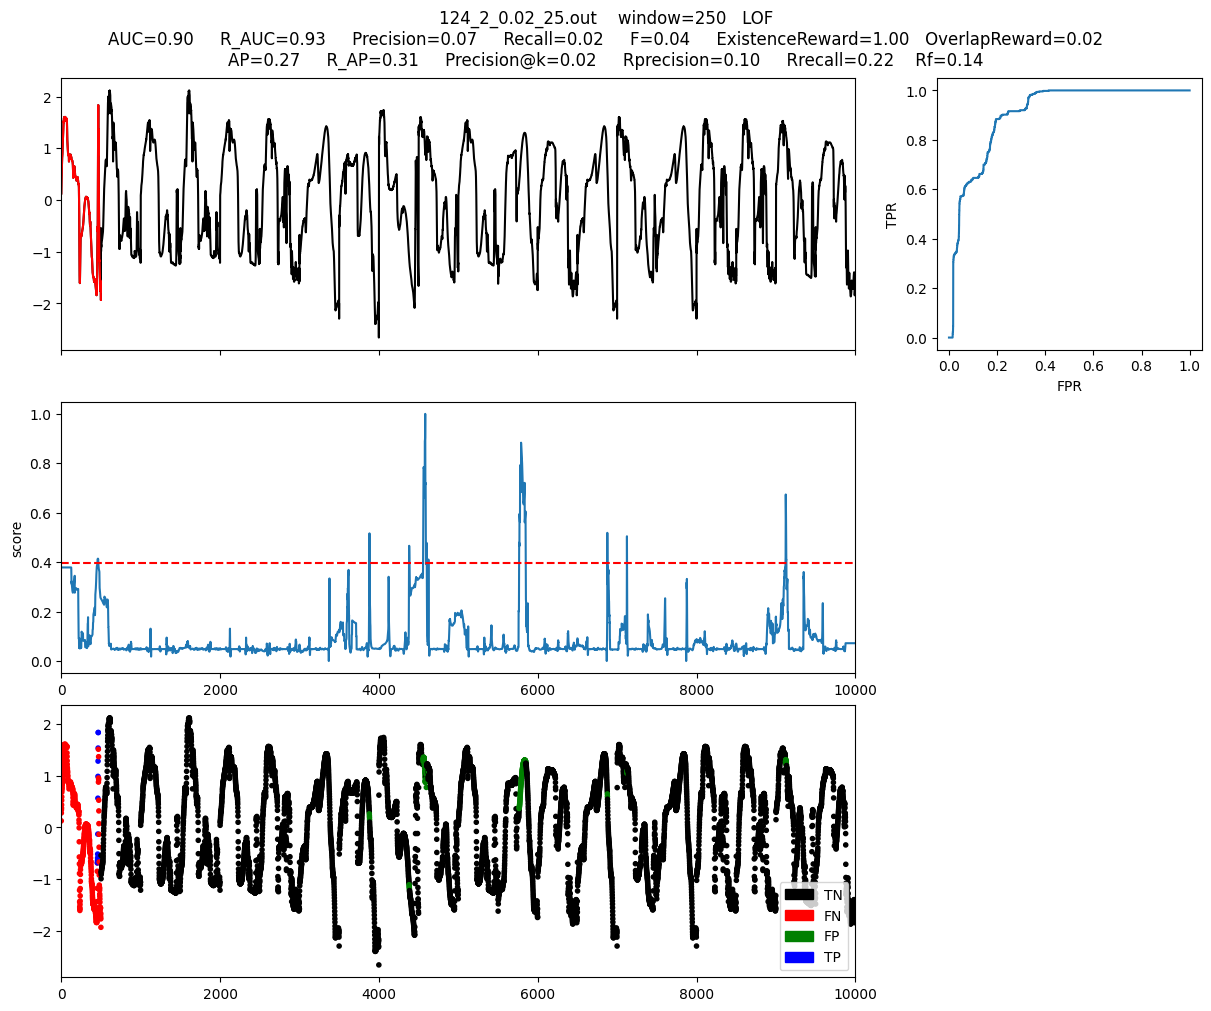

In [8]:
modelName='LOF'
clf = LOF(n_neighbors=20, n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) 

0 499
473 624
1499 1624
3358 3464
3866 4101
4417 4562
5016 5024
6410 6437
6858 7101
7858 8100
8499 8569
8966 9069


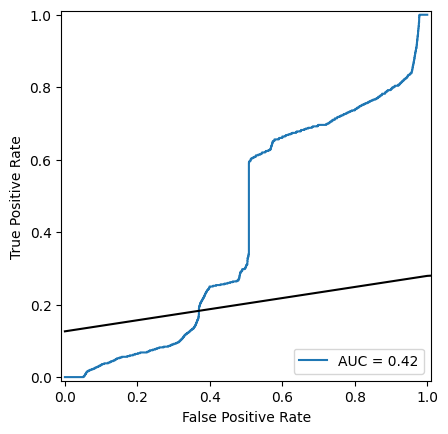

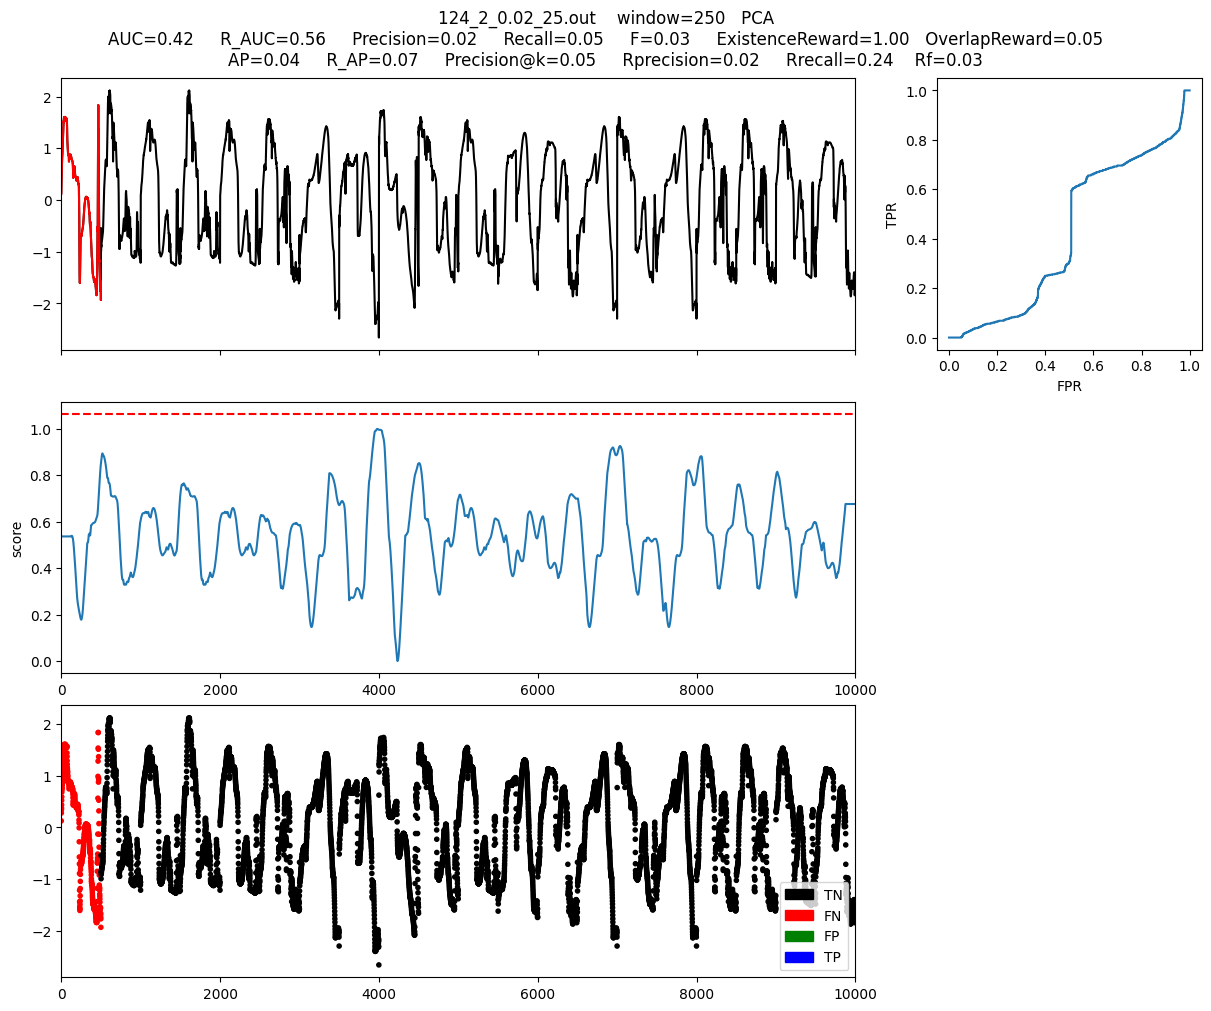

In [9]:
modelName='PCA'
clf = PCA()
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

0 499
500 749
9750 9999


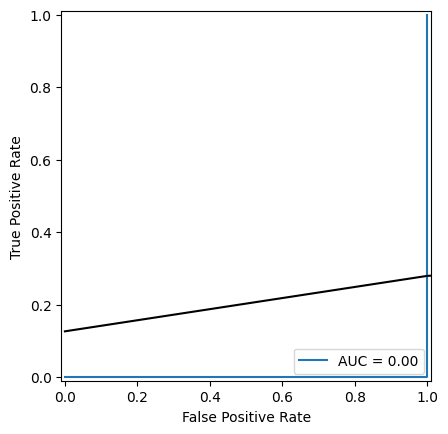

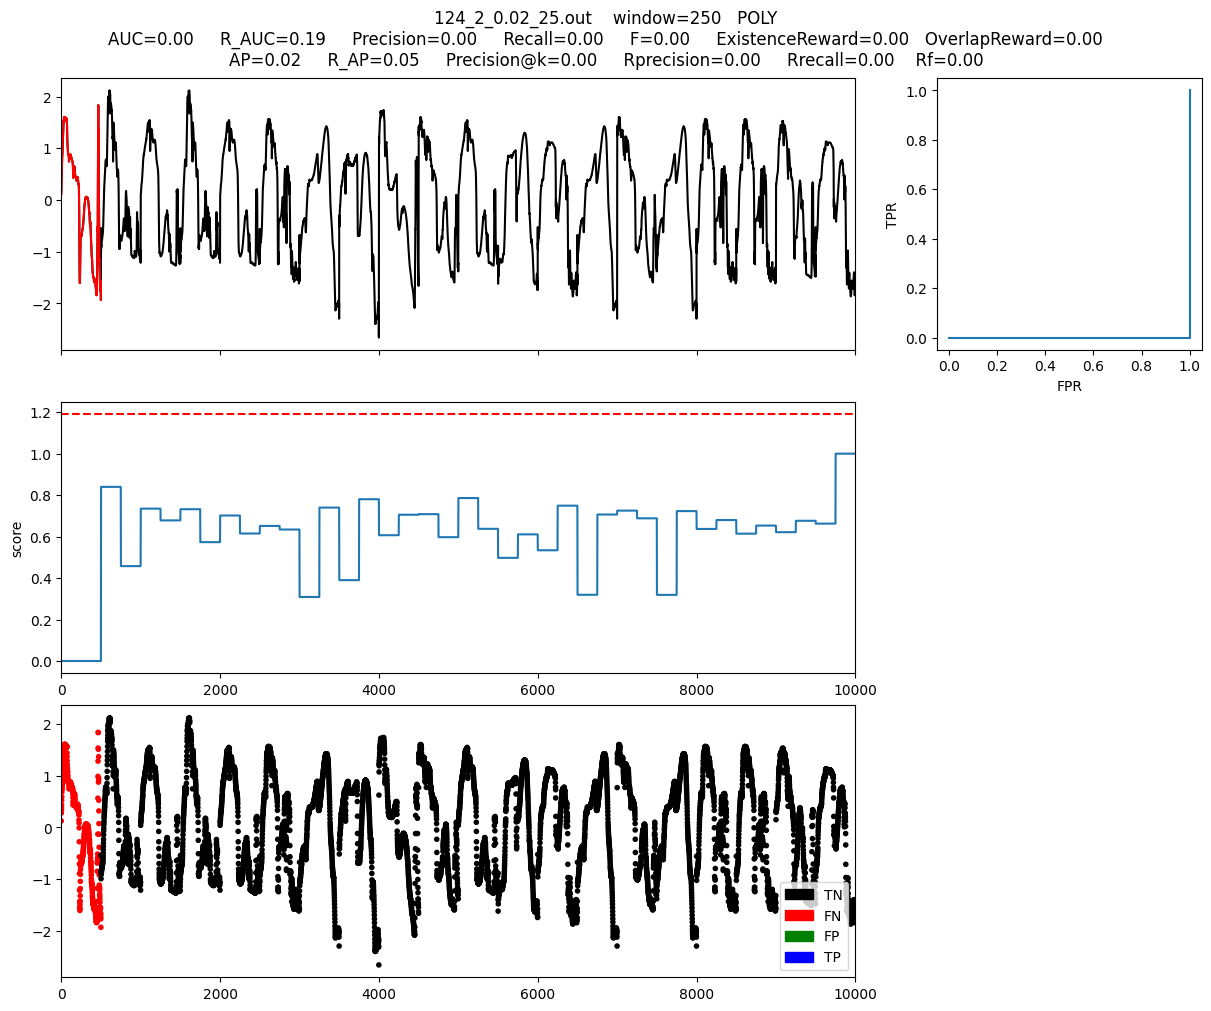

In [10]:
modelName='POLY'
clf = POLY(power=3, window = slidingWindow)
x = data
clf.fit(x)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

0 499
1139 1203
1482 1495
2139 2203
3534 3787
4501 4569
5139 5203
5599 5678
6054 6245
6380 6405
6882 6896
6902 6972
7013 7112
8068 8078
8899 8904
8978 9097
9398 9425
9428 9430
9574 9745


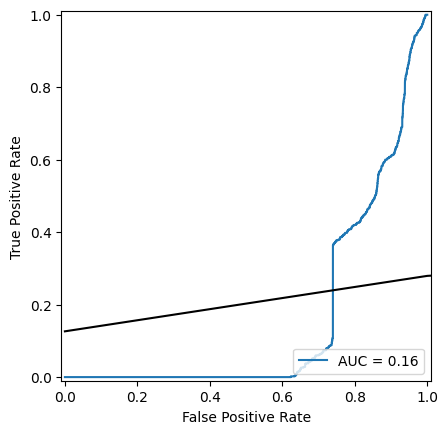

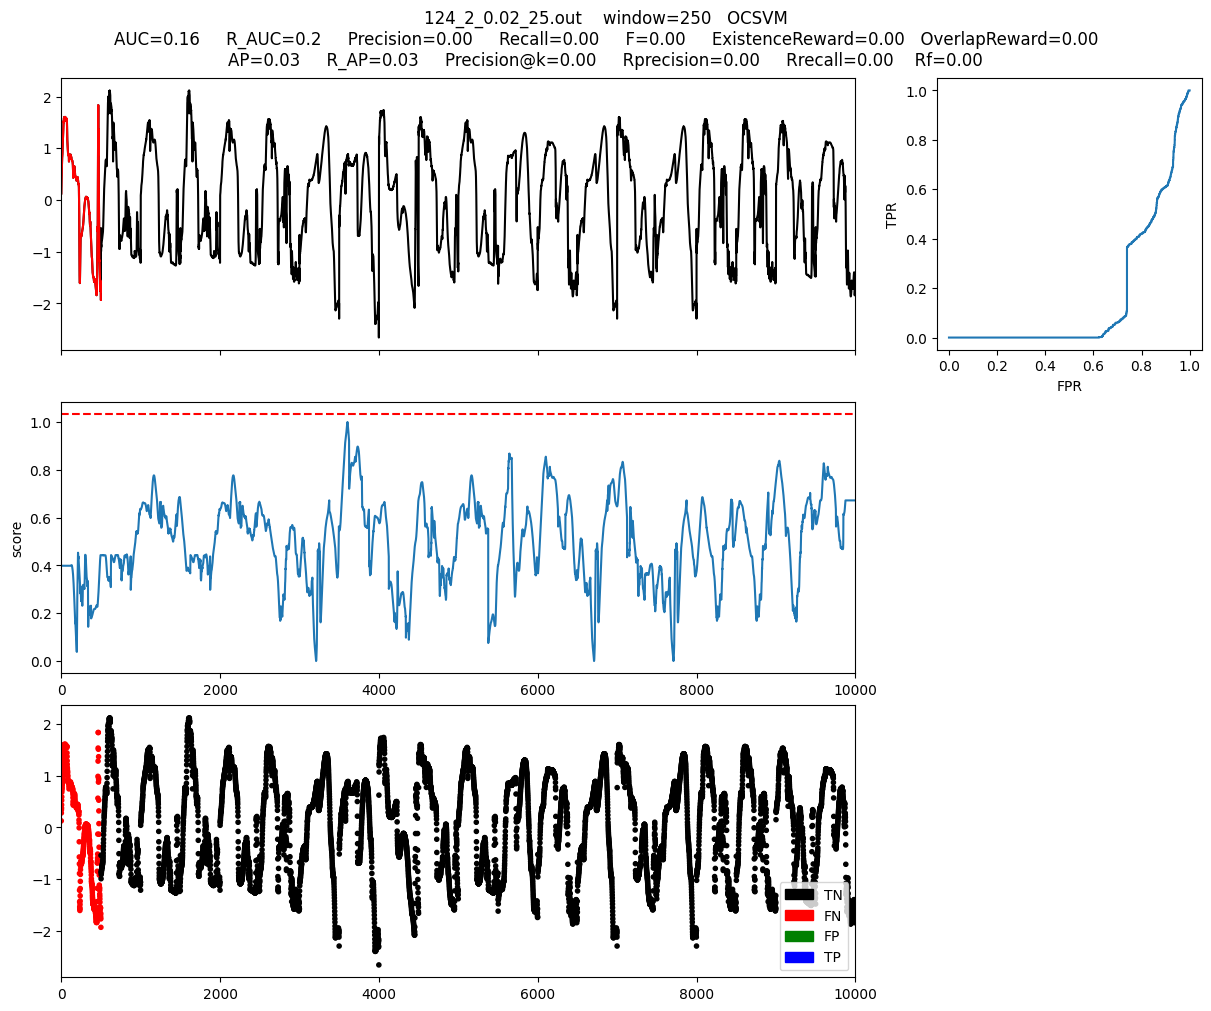

In [11]:
modelName='OCSVM'
X_train_ = MinMaxScaler(feature_range=(0,1)).fit_transform(X_train.T).T
X_test_ = MinMaxScaler(feature_range=(0,1)).fit_transform(X_test.T).T

clf = OCSVM(nu=0.05)
clf.fit(X_train_, X_test_)


score = clf.decision_scores_
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

305/305 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step
0 499
453 454
461 464
468 468
500 500
953 953
959 959
1000 1003
1452 1454
1459 1459
1469 1470
1500 1500
1953 1953
1959 1959
2000 2003
2452 2454
2459 2459
2469 2470
2500 2500
2726 2728
2839 2841
3000 3000
3500 3502
4000 4003
4455 4457
4477 4477
4500 4503
4955 4956
4970 4972
5000 5002
5452 5454
5459 5459
5469 5470
5501 5501
6000 6000
6228 6228
6364 6365
6370 6370
6378 6381
6500 6500
7000 7003
7455 7456
7470 7472
7500 7500
8000 8000
8339 8341
8500 8500
8727 8728
8839 8841
9000 9002
9451 9454
9459 9459
9468 9470
9500 9500
9728 9728
9864 9865
9870 9870
9878 9881


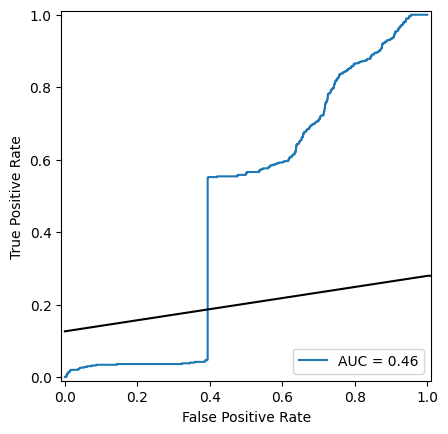

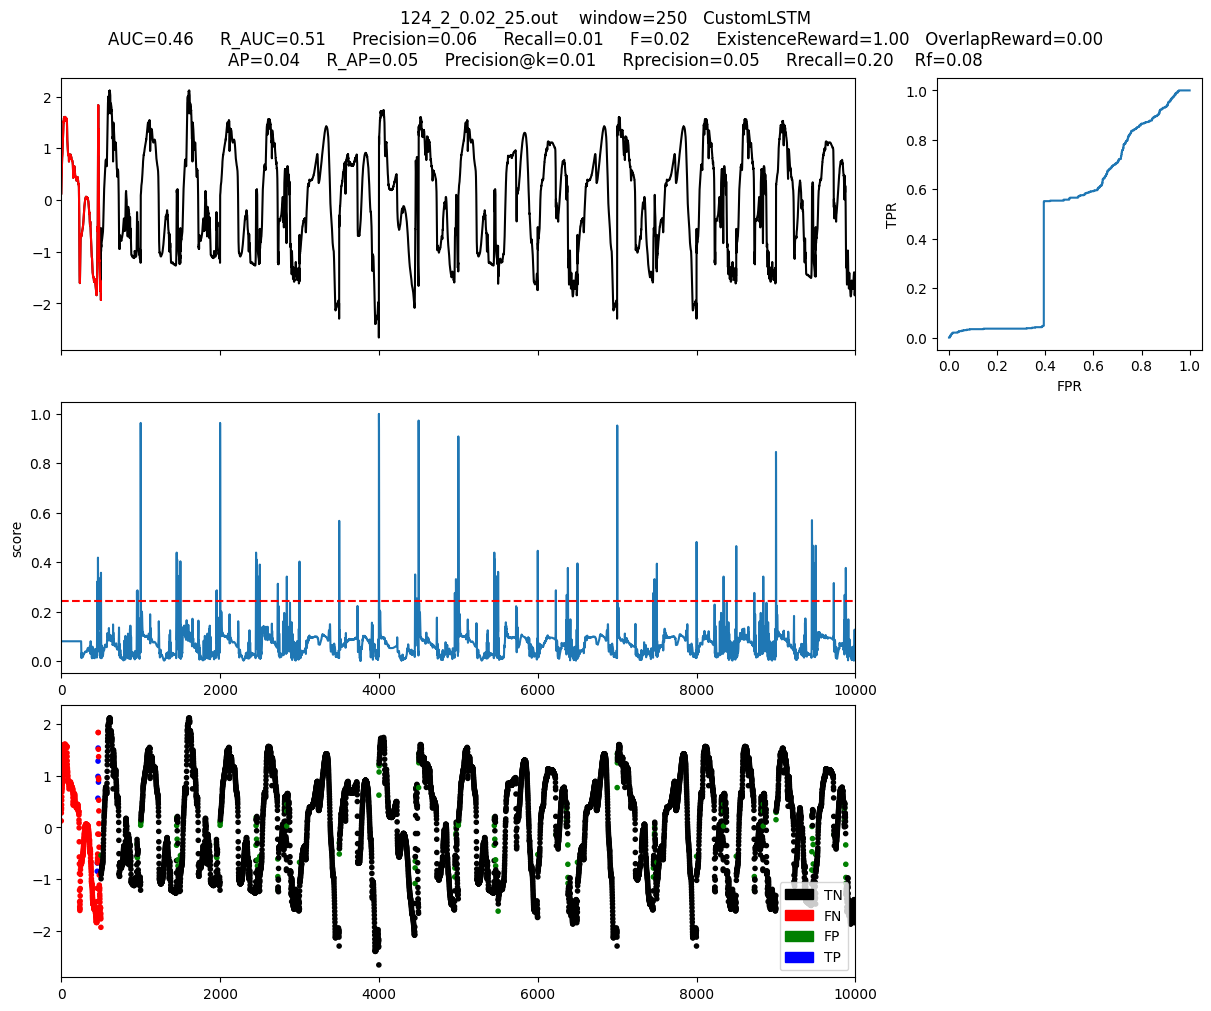

In [17]:
modelName='CustomLSTM'
clf = CustomLstm(slidingwindow = slidingWindow, predict_time_steps=1, epochs = 50, patience = 5, verbose=0)
clf.fit(data_train, data_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
0 499
2462 2463
3801 3811
3918 3918
3922 3922
3924 3925
3928 3930
3932 3932
5513 5515
5798 5803
6911 6934
9381 9381
9459 9465


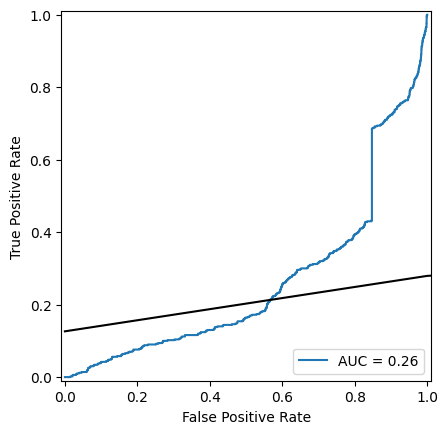

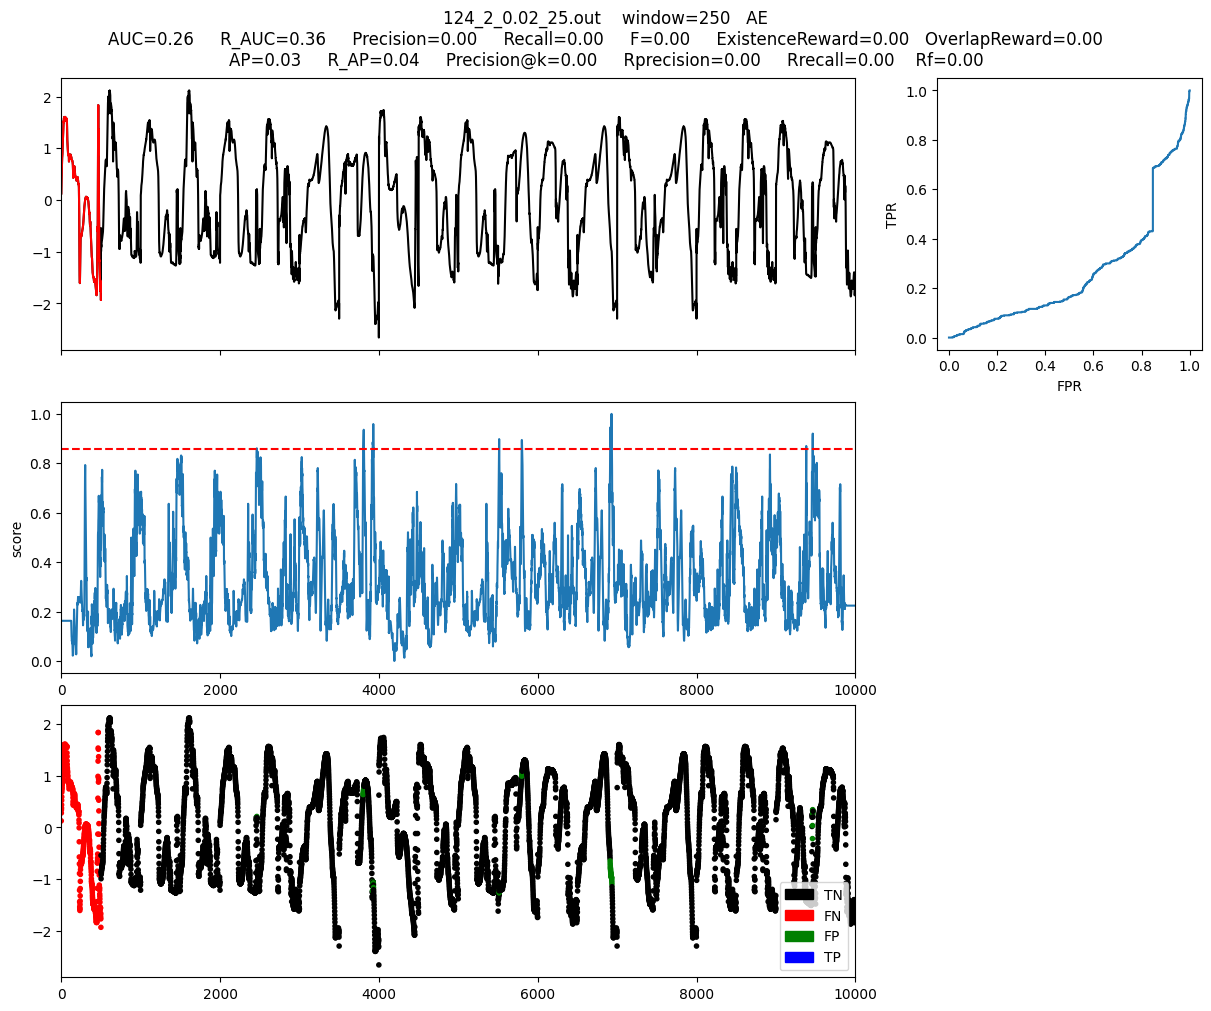

In [14]:
modelName='AE'
clf = AE_MLP2(slidingWindow = slidingWindow, epochs=100, verbose=0)

clf.fit(data_train, data_test)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0 499
461 466
1000 1016
2000 2016
2728 2728
3378 3388
4000 4012
4462 4466
4501 4505
5000 5009
6878 6888
7000 7011
7878 7888
8539 8540
9000 9011
9032 9033
9454 9455


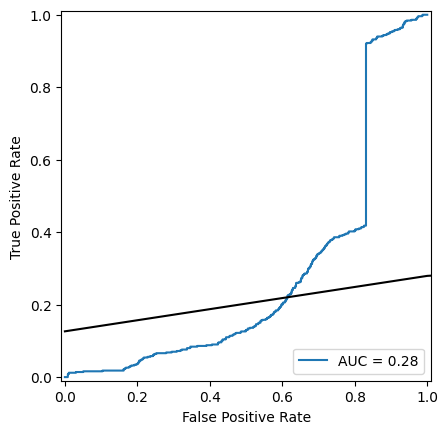

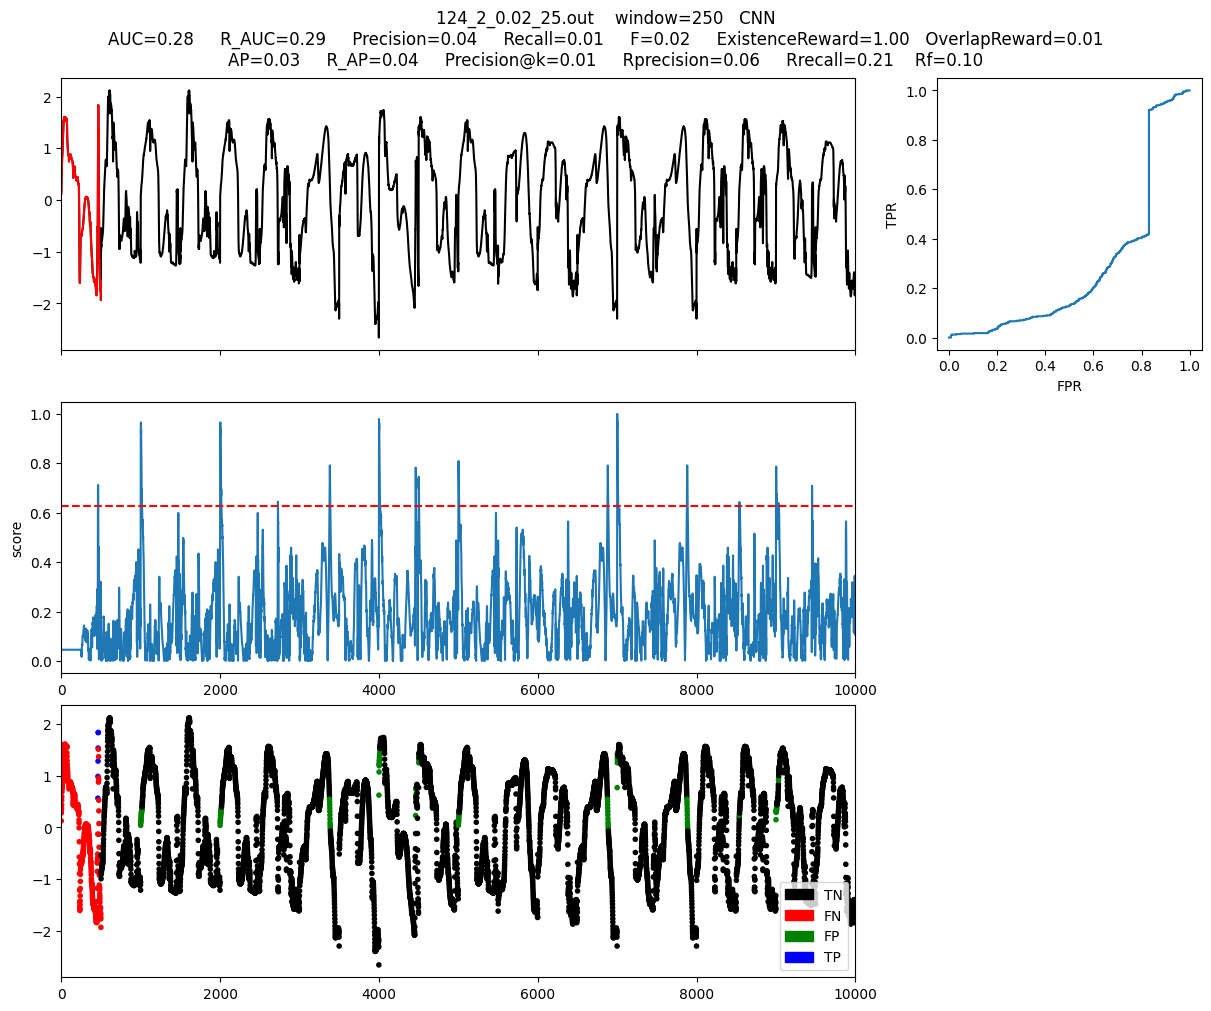

In [15]:
modelName='CNN'
clf = cnn(slidingwindow = slidingWindow, predict_time_steps=1, epochs = 100, patience = 5, verbose=0)

clf.fit(data_train, data_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)